# Import

In [1396]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge
from sklearn.impute import IterativeImputer


# Chargement de la données

In [1397]:
chemin_fichier = "data/train.csv"
df = pd.read_csv(chemin_fichier)
# print(df.head())

# Transformation de la données

In [1398]:
# Calcul du nombre de valeurs manquantes par colonne
missing_values_count = df.isnull().sum()

# Afficher les colonnes avec le nombre de valeurs manquantes
print("Nombre de valeurs manquantes par colonne:")
print(missing_values_count)

# Filtrer pour obtenir uniquement les colonnes avec des valeurs manquantes
columns_with_na = missing_values_count[missing_values_count > 0].index.tolist()

# Afficher uniquement les colonnes avec des valeurs manquantes
print("\nDataFrame avec uniquement les colonnes ayant des valeurs manquantes:")
print(df[columns_with_na])

Nombre de valeurs manquantes par colonne:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

DataFrame avec uniquement les colonnes ayant des valeurs manquantes:
     HomePlanet CryoSleep     Cabin    Destination   Age    VIP  RoomService  \
0        Europa     False     B/0/P    TRAPPIST-1e  39.0  False          0.0   
1         Earth     False     F/0/S    TRAPPIST-1e  24.0  False        109.0   
2        Europa     False     A/0/S    TRAPPIST-1e  58.0   True         43.0   
3        Europa     False     A/0/S    TRAPPIST-1e  33.0  False          0.0   
4         Earth     False     F/1/S    TRAPPIST-1e  16.0  False        303.0   
...         ...       ...       ...            ...   ...    ...          ...   
8688     Europa     False    A/98/P

In [1399]:
# Compter le nombre total de lignes
total_rows = len(df)
print("Nombre total de lignes:", total_rows)

# Compter les lignes contenant au moins une valeur manquante
rows_with_na = df.isnull().any(axis=1).sum()
print("Nombre de lignes avec au moins une valeur manquante:", rows_with_na)

# Compter le nombre de ligne avec n valeur(s) manquante(s)
n_nan_required = 1;
nan_counts = df.isnull().sum(axis=1)
count_n_nan = (nan_counts == n_nan_required).sum()
print(f"Nombre de lignes avec exactement {n_nan_required} valeurs manquantes: {count_n_nan}")

Nombre total de lignes: 8693
Nombre de lignes avec au moins une valeur manquante: 2087
Nombre de lignes avec exactement 1 valeurs manquantes: 1867


In [1400]:
# Initialisation de l'IterativeImputer
colonnes_numeriques = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

imputer = IterativeImputer(estimator=BayesianRidge(),
                           max_iter=10,
                           verbose=2,
                           random_state=42)
# Df histo 
df_orig = df.copy(deep=True)# Imputation
df[colonnes_numeriques] = imputer.fit_transform(df[colonnes_numeriques])

# Affichage
print(df[colonnes_numeriques].isnull().sum())

[IterativeImputer] Completing matrix with shape (8693, 6)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.02
[IterativeImputer] Change: 2579.328974680969, scaled tolerance: 29.813000000000002 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.05
[IterativeImputer] Change: 85.8027477445919, scaled tolerance: 29.813000000000002 
[IterativeImputer] Ending imputation round 3/10, elapsed time 0.07
[IterativeImputer] Change: 3.3544822285639384, scaled tolerance: 29.813000000000002 
[IterativeImputer] Early stopping criterion reached.
Age             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64


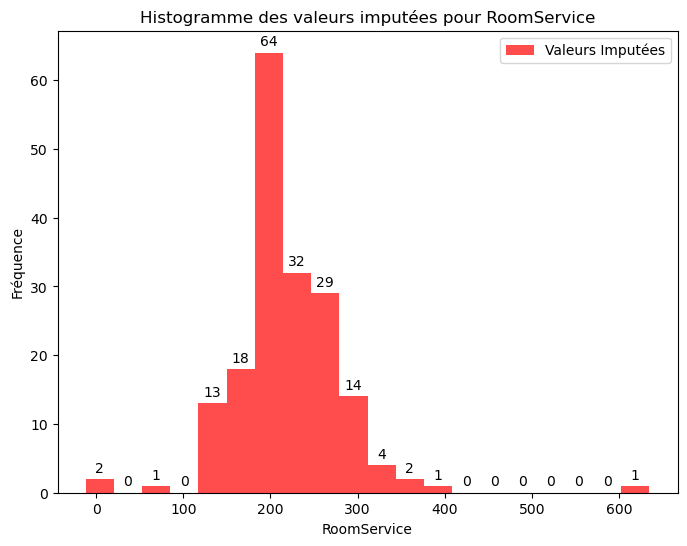

In [1401]:
# Affichage apres imputation par colonne
colonne = 'RoomService'

indices_modifies = np.where(np.isnan(df_orig[colonne]) & ~np.isnan(df[colonne]))

# S'assurer que nous utilisons les indices corrects pour accéder aux valeurs imputées dans df
valeurs_imputees = df.iloc[indices_modifies][colonne]

# Vérifier si 'valeurs_imputees' contient des données
if not valeurs_imputees.empty:
    plt.figure(figsize=(8, 6))
    n, bins, patches = plt.hist(valeurs_imputees, bins=20, color='red', alpha=0.7, label='Valeurs Imputées')
    plt.title('Histogramme des valeurs imputées pour ' + colonne)
    plt.xlabel(colonne)
    plt.ylabel('Fréquence')
    plt.legend()

    # Ajouter les annotations sur les barres
    for i in range(len(patches)):
        plt.annotate(str(int(n[i])), (patches[i].xy[0] + patches[i]._width / 2, n[i] + 1), ha='center')

    plt.show()
else:
    print("Aucune valeur imputée à afficher.")

In [1402]:
# Passenger_ID, séparation de la variable en deux variables Groupe_Numero
df[['Groupe', 'Numero']] = df['PassengerId'].str.split('_', expand=True)
df.drop('PassengerId', axis=1, inplace=True)
# print(df.head())

In [1403]:
# HomePlanet, OneHotEncoding
df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
df = pd.get_dummies(df, columns=['HomePlanet'])
# print(df.head())

In [1404]:
# Cabin,  séparation de la variable en trois champs : pont/num/côté
df['Cabin'] = df['Cabin'].fillna('0/0/0')
df[['Pont', 'Num', 'Cote']] = df['Cabin'].str.split('/', expand=True)
df.drop('Cabin', axis=1, inplace=True)
# print(df.head())

In [1405]:
# Destination, OneHotEncoding
df['Destination'] = df['Destination'].fillna('Unknown')
df = pd.get_dummies(df, columns=['Destination'])
# print(df.head())

In [1406]:
# nb_false = (df['CryoSleep'] == False).sum()
# nb_true = (df['CryoSleep'] == True).sum()
# print("Nombre de valeurs False dans 'CryoSleep':", nb_false)
# print("Nombre de valeurs True dans 'CrySleep':", nb_true)

# Remplacement des null par False
df['CryoSleep'] = df['CryoSleep'].fillna(False)

In [1407]:
# nb_false = (df['VIP'] == False).sum()
# nb_true = (df['VIP'] == True).sum()
# print("Nombre de valeurs False dans 'VIP':", nb_false)
# print("Nombre de valeurs True dans 'VIP':", nb_true)

# Remplacement des null par False
df['VIP'] = df['VIP'].fillna(False)

In [1408]:
#Suppression de la colonne Name
df.drop('Name', axis=1, inplace=True)

## Conversion des types

In [1409]:
df['CryoSleep'].astype(bool)
df['Age'].astype(int)
df['VIP'].astype(bool)
df['RoomService'].astype(int)
df['FoodCourt'].astype(int)
df['ShoppingMall'].astype(int)
df['Spa'].astype(int)
df['VRDeck'].astype(int)
df['Transported'].astype(bool)
df['Groupe'] = pd.to_numeric(df['Groupe'], errors='coerce')
df['Numero'] = pd.to_numeric(df['Numero'], errors='coerce')
df['HomePlanet_Earth'].astype(bool)
df['HomePlanet_Europa'].astype(bool)
df['HomePlanet_Mars'].astype(bool)
df['HomePlanet_Unknown'].astype(bool)
df['Num'] = pd.to_numeric(df['Num'], errors='coerce')
df['Destination_55 Cancri e'].astype(bool)
df['Destination_PSO J318.5-22'].astype(bool)
df['Destination_TRAPPIST-1e'].astype(bool)
df['Destination_Unknown'].astype(bool)

# LabelEncoding : Vient attribuer un nombre unique a chaque catgeorie
# Création de l'encodeur
label_encoder = LabelEncoder()
# Fit et transform
df['Pont'] = label_encoder.fit_transform(df['Pont'])
df['Cote'] = label_encoder.fit_transform(df['Cote'])

#Affichage 
print(df.head())

   CryoSleep   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  \
0      False  39.0  False          0.0        0.0           0.0     0.0   
1      False  24.0  False        109.0        9.0          25.0   549.0   
2      False  58.0   True         43.0     3576.0           0.0  6715.0   
3      False  33.0  False          0.0     1283.0         371.0  3329.0   
4      False  16.0  False        303.0       70.0         151.0   565.0   

   VRDeck  Transported  Groupe  ...  HomePlanet_Europa  HomePlanet_Mars  \
0     0.0        False       1  ...               True            False   
1    44.0         True       2  ...              False            False   
2    49.0        False       3  ...               True            False   
3   193.0        False       3  ...               True            False   
4     2.0         True       4  ...              False            False   

   HomePlanet_Unknown  Pont  Num  Cote  Destination_55 Cancri e  \
0               False     2    

In [1410]:
# Enregistrement du DataSet dans un csv
try:
    df.to_csv('data/dataset.csv', index=False)
    print("Fichier enregistré avec succès.")
except Exception as e:
    print(f"Erreur lors de l'enregistrement du fichier : {e}")

Fichier enregistré avec succès.


In [1411]:
# Supprimer les lignes contenant des NaN
# df = df.dropna()

# Entraînement du modèle

In [1412]:
# Séparation des features et de la cible
X = df.drop('Transported', axis=1) 
y = df['Transported']

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalisation des données 
# Standardisation (Z-score Normalization)
scaler = StandardScaler()
scaler.fit(X_train)  # Calculer la moyenne et l'écart-type uniquement sur les données d'entraînement

X_train = scaler.transform(X_train)  # Transformer les données d'entraînement
X_test = scaler.transform(X_test)    # Transformer les données de test avec le même transformateur

# Créer une instance du modèle
model = LogisticRegression()

# Entraîner le modèle
model.fit(X_train, y_train)

LogisticRegression()

# Prédiction et évaluation

In [1413]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Calcul de la précision
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision: {accuracy}")

# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

Précision: 0.776840490797546


In [1414]:
# Afficher l'importance de chaque variable
importance = model.coef_[0]
for i, v in enumerate(importance):
    print(f'Feature: {X.columns[i]}, Score: {v}')

Feature: CryoSleep, Score: 0.6729707811534461
Feature: Age, Score: -0.07631237749760024
Feature: VIP, Score: -0.0661623334720743
Feature: RoomService, Score: -1.000420441165189
Feature: FoodCourt, Score: 0.8505217733291686
Feature: ShoppingMall, Score: 0.3731142458449579
Feature: Spa, Score: -2.1800555198518556
Feature: VRDeck, Score: -2.0688738519308973
Feature: Groupe, Score: -0.100771918628675
Feature: Numero, Score: 0.05055124275420946
Feature: HomePlanet_Earth, Score: -0.37453406364302083
Feature: HomePlanet_Europa, Score: 0.5010549378946078
Feature: HomePlanet_Mars, Score: -0.06091396249631094
Feature: HomePlanet_Unknown, Score: -0.030859862176699514
Feature: Pont, Score: -0.31179112676184384
Feature: Num, Score: 0.2530953271059244
Feature: Cote, Score: 0.3271349708462617
Feature: Destination_55 Cancri e, Score: 0.10941337787441674
Feature: Destination_PSO J318.5-22, Score: -0.041267429796921495
Feature: Destination_TRAPPIST-1e, Score: -0.07688807492556544
Feature: Destination_Un

# Visualisation des résultats

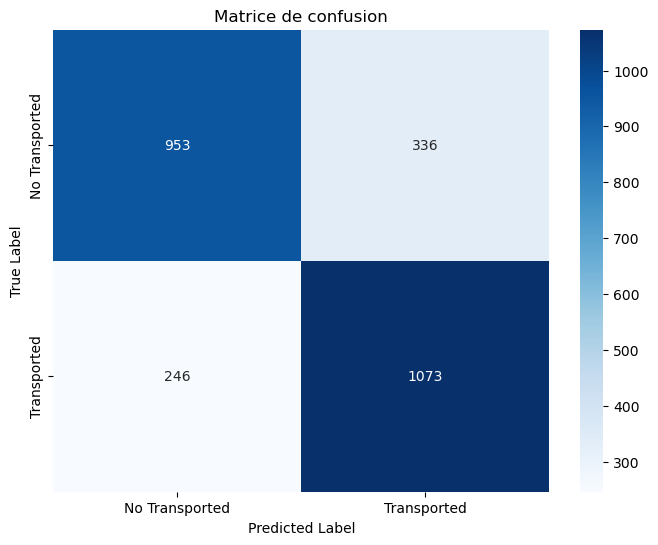

In [1415]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['No Transported', 'Transported'], yticklabels=['No Transported', 'Transported'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Matrice de confusion')
plt.show()